In [143]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import random
import GPy
import sqlalchemy as sa
import config
import climin
import hdbscan
from tqdm import tqdm_notebook as tqdm
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.distributions.empirical_distribution import ECDF
from helpers import plot_histogram, counter_histogram, paired_histogram, multi_scatter
from plotly.tools import make_subplots
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Contours, Marker, Histogram2dContour, Scatter
import plotly.graph_objs as go
from collections import Counter

%matplotlib inline
init_notebook_mode(connected=True)
plt.rcParams['figure.figsize'] = (12, 5)
engine = sa.create_engine(config.database_uri)

In [2]:
base_columns = set(("job_db_inx", "gres_req", "cpus_req", "mem_req", "time_submit", "time_start", "time_end",
                   "time_suspended", "nodelist", "job_name"))
query = 'select ' + ", ".join(base_columns) + ' from longleaf_job_table where nodelist like %s;'
df = pd.read_sql_query(query, engine, params=[r"%g060%"])

In [3]:
df.describe()

,mem_req,cpus_req,job_db_inx,time_suspended,time_end,time_submit,time_start
count,3.998000e+03,3998.000000,3.998000e+03,3998.000000,3.998000e+03,3.998000e+03,3.998000e+03
mean,3.144436e+18,1.886943,4.259093e+06,0.072286,1.489035e+09,1.492021e+09,1.492021e+09
std,4.372597e+18,2.498080,1.423148e+06,4.570634,6.673566e+07,2.648291e+06,2.648583e+06
min,2.000000e+00,1.000000,1.641614e+06,0.000000,0.000000e+00,1.486399e+09,1.486399e+09
25%,2.147488e+09,1.000000,3.688383e+06,0.000000,1.490227e+09,1.490226e+09,1.490226e+09
50%,2.147488e+09,1.000000,4.210054e+06,0.000000,1.491336e+09,1.491348e+09,1.491348e+09
75%,9.223372e+18,1.000000,5.290355e+06,0.000000,1.494612e+09,1.494614e+09,1.494614e+09
max,9.223372e+18,16.000000,6.896533e+06,289.000000,1.496874e+09,1.496871e+09,1.496871e+09


In [4]:
start_date = datetime.fromtimestamp(df["time_submit"].min())
end_date = datetime.fromtimestamp(df["time_submit"].max())
print("start: %s, end: %s" % (start_date, end_date))

start: 2017-02-06 11:38:14, end: 2017-06-07 17:24:31


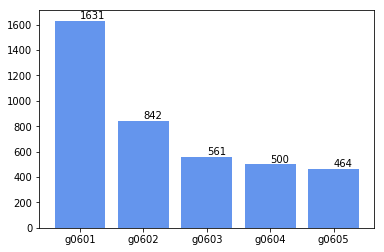

In [5]:
counter_histogram(df["nodelist"]);

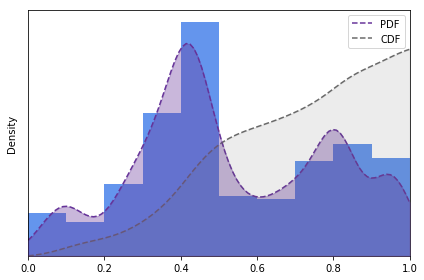

In [6]:
df_min = df["time_submit"].min()
max_time_diff = df["time_submit"].max() - df_min

plot_histogram((df["time_submit"] - df_min) / max_time_diff);

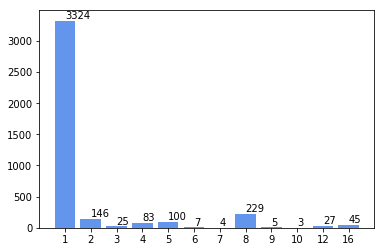

In [7]:
counter_histogram(df["cpus_req"]);

In [8]:
pending = pd.Series(df["time_start"] - df["time_submit"], index=df.index, name="pending")

pending.describe()

count     3998.000000
mean       286.518009
std       3346.759689
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max      99862.000000
Name: pending, dtype: float64

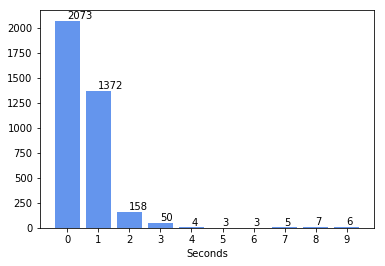

In [9]:
fig = counter_histogram(pending[pending < 10])
fig.axes[0].set_xlabel("Seconds");

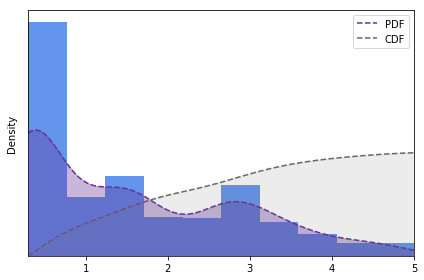

In [10]:
plot_histogram(np.log10(pending[pending > 1]));

When log transformed, the distribution of pending is vaguely exponential.

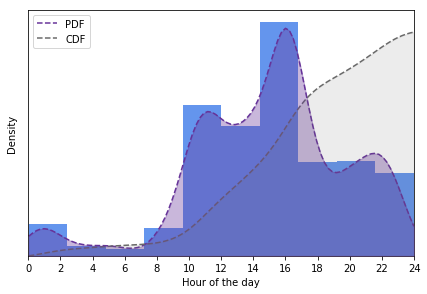

In [11]:
def day_seconds(s):
    dt = datetime.fromtimestamp(s).time()
    return 3600 * dt.hour + 60 * dt.minute + dt.second

time_of_day = df["time_submit"].apply(lambda s: day_seconds(s)).rename("seconds_of_day")
time_of_day
fig = plot_histogram(time_of_day.apply(lambda s: s / 86400.0 * 24.0));
fig.axes[0].set_xticks(range(25)[::2]);
fig.axes[0].set_xlabel("Hour of the day");

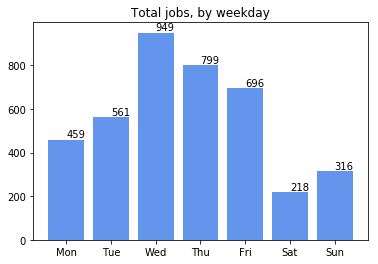

In [12]:
def weekday(s):
    dt = datetime.fromtimestamp(s)
    return dt.weekday()

day_of_week = df["time_submit"].apply(lambda s: weekday(s)).rename("day_of_week")
fig = counter_histogram(day_of_week)
fig.axes[0].set_title("Total jobs, by weekday")
fig.axes[0].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]);

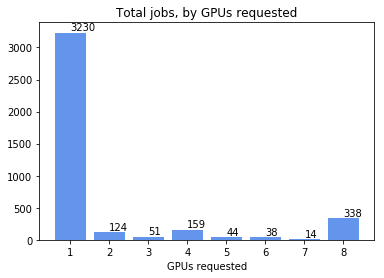

In [13]:
gpus_req = df["gres_req"].apply(lambda x: int(x.split(":")[-1] or 1)).rename("gpus_req")

fig = counter_histogram(gpus_req);
fig.axes[0].set_title("Total jobs, by GPUs requested")
fig.axes[0].set_xlabel("GPUs requested");

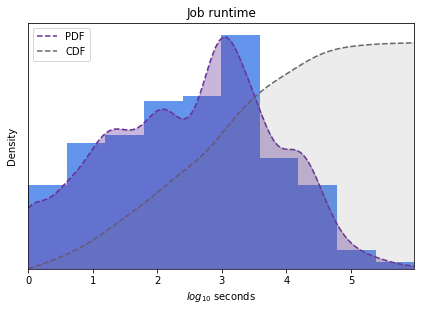

In [14]:
mask = df["time_end"] >= df["time_start"]
masked = df[mask]
runtime = pd.Series(masked["time_end"] - masked["time_start"] - masked["time_suspended"], name="runtime")

fig = plot_histogram(np.log10(runtime + 1))
fig.axes[0].set_title("Job runtime")
fig.axes[0].set_xlabel(r"$log_{10}$ seconds");

In [131]:
expanded_df = df.join(pending).join(time_of_day).join(day_of_week).join(gpus_req).join(runtime)
excluded_cols = ["job_db_inx", "time_suspended", "mem_req", "time_submit", "time_start", "time_end", "day_of_week", "seconds_of_day"]

In [132]:
by_gpus = expanded_df.groupby("gpus_req")
gpu_means = by_gpus.mean()

gpu_means.drop(excluded_cols, axis=1)

,cpus_req,pending,runtime
gpus_req,,,
1,1.441176,277.730031,7066.467577
2,2.919355,0.620968,771.040323
3,1.098039,0.470588,7622.470588
4,4.974843,76.314465,16584.145570
5,2.159091,0.795455,3845.113636
6,4.921053,734.815789,8421.131579
7,1.000000,0.500000,205.857143
8,4.094675,616.068047,20423.562130


In [133]:
by_nodes = expanded_df.groupby("nodelist")

by_nodes.mean().drop(excluded_cols, axis=1)

,cpus_req,pending,gpus_req,runtime
nodelist,,,,
g0601,1.955242,8.980993,1.654813,7614.485574
g0602,2.053444,90.659145,1.997625,11676.923810
g0603,1.787879,1039.146168,2.169340,7444.932264
g0604,1.488000,231.256000,1.784000,9148.788732
g0605,1.894397,767.084052,2.213362,5051.708423


In [134]:
by_cpus = expanded_df.groupby("cpus_req")
by_cpus.mean().drop(excluded_cols + ["seconds_of_day", "day_of_week"], axis=1)

,pending,gpus_req,runtime
cpus_req,,,
1,259.903430,1.600481,6634.527076
2,156.123288,1.547945,2588.869863
3,3.160000,2.680000,480.520000
4,1.192771,1.831325,4076.937500
5,0.630000,2.280000,52695.020000
6,0.285714,2.285714,63.000000
7,0.500000,2.250000,157.000000
8,1127.912664,5.305677,23269.602679
9,0.000000,8.000000,793.400000


In [61]:
def get_resource_use(df):
    sum_cpus = []
    sum_gpus = []
    mask = df["time_end"] >= df["time_start"]
    all_times = pd.Series(list(df[mask]["time_start"]) + list(df[mask]["time_end"]), name="time")

    for t in all_times:
        started_before = df["time_start"] <= t
        ended_after = df["time_end"] >= t
        active = df[started_before & ended_after]
        cpus = active["cpus_req"].sum()
        gpus = active["gpus_req"].sum()
        sum_cpus.append(cpus)
        sum_gpus.append(gpus)
    
    sum_cpus = pd.Series(sum_cpus, name="sum_cpus")
    sum_gpus = pd.Series(sum_gpus, name="sum_gpus")
    
    return pd.concat([all_times, sum_cpus, sum_gpus], axis=1)

use_df = get_resource_use(expanded_df)
sum_cpus = use_df["sum_cpus"]
sum_gpus = use_df["sum_gpus"]

In [56]:
use_df.describe()

,time,sum_cpus,sum_gpus
count,7.980000e+03,7980.000000,7980.000000
mean,1.492016e+09,11.468546,13.317419
std,2.643383e+06,8.760571,8.853099
min,1.486399e+09,1.000000,1.000000
25%,1.490227e+09,5.000000,7.000000
50%,1.491342e+09,10.000000,12.000000
75%,1.494611e+09,17.000000,18.000000
max,1.496874e+09,43.000000,43.000000


In [44]:
fig = paired_histogram(cpus, gpus, "Total CPUs", "Total GPUs")
iplot(fig)

In [112]:
idxs, data = zip(*expanded_df.groupby("nodelist"))
uses = [get_resource_use(d).sort_values("time") for d in data]

In [113]:
def utilization_plot(dfs):
    fig = make_subplots(rows=5, cols=1)
    for i, df in enumerate(dfs, start=1):
        times = [datetime.fromtimestamp(x) for x in df["time"]]
        cpu = go.Scatter(x=times, y=df["sum_cpus"], fill='tozeroy', name="G060%s CPU use" % i)
        gpu = go.Scatter(x=times, y=df["sum_gpus"], fill='tozeroy', name="G060%s GPU use" % i)
        fig.append_trace(cpu, i, 1)
        fig.append_trace(gpu, i, 1)
    fig["layout"].update(height=1000, width=600)
    return iplot(fig)

utilization_plot(uses)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]
[ (5,1) x5,y5 ]



In [63]:
expanded_df = expanded_df.join(sum_cpus).join(sum_gpus)

In [93]:
mask = expanded_df["pending"] > 4

norm = expanded_df.groupby(["nodelist", "gpus_req", "cpus_req"])
norm_counts = norm.count().rename(columns=lambda c: "n_%s" % c)

err = expanded_df[mask].groupby(["nodelist", "gpus_req", "cpus_req"])
err_counts = err.count().rename(columns=lambda c: "c_%s" % c).join(norm_counts)
err_med = err.mean().rename(columns=lambda c: "m_%s" % c)
err_prob = pd.Series(err_counts["c_job_db_inx"] / err_counts["n_job_db_inx"], name="err_prob")

combined = pd.concat([err_counts, err_med, err_prob], axis=1)
pending_only_columns = ["c_job_db_inx", "err_prob", "m_pending"]
pending_count = combined[pending_only_columns].where(lambda x: x["m_pending"] > 10).dropna()
pending_count.rename(columns={"c_job_db_inx": "count", "m_pending": "mean_pending"})

count  err_prob  mean_pending
nodelist gpus_req cpus_req                               
g0601    1        1          16.0  0.012841    651.062500
                  2           3.0  0.166667     33.333333
         2        2           2.0  0.043478     16.500000
         4        1           2.0  0.500000    306.500000
                  8           4.0  0.190476     25.250000
         6        12          3.0  0.230769     14.666667
         8        1           1.0  0.015625   2402.000000
                  16          7.0  1.000000     24.571429
g0602    1        1          19.0  0.031561   3990.947368
         2        4           2.0  0.133333     10.500000
         4        8           1.0  0.062500     21.000000
         8        8           1.0  0.017544     25.000000
g0603    1        1          80.0  0.198020   4592.175000
                  2           1.0  0.090909   9640.000000
         4        1           7.0  0.388889     25.714286
         8        1           8.0  0.195122  25689.625000
g0604    1        1         117.0  0.303896    950.102564
                  2           1.0  0.076923     35.000000
         4        8           2.0  0.400000   2114.500000
g0605    1        1          44.0  0.144262   1227.681818
                  2           1.0  0.055556  12958.000000
                  3           5.0  1.000000     13.200000
                  8           7.0  0.333333  36268.857143
         4        1           2.0  0.222222   3445.500000
                  4           1.0  0.250000     39.000000
         6        1           1.0  0.142857  27850.000000

In [138]:
min_time = expanded_df["time_submit"].min()

def days(s):
    return np.floor((s - min_time) / 86400.0)

In [139]:
day = pd.Series(expanded_df["time_submit"].apply(days), name="day")
expanded_df = expanded_df.join(day)

## Jobs per day

In [147]:
iplot(multi_scatter(expanded_df))

## Jobs with a pending time greater than 4 seconds per day

In [148]:
iplot(multi_scatter(expanded_df[high_pending_mask]))

Since this plot doesn't show a spike in pending for nodes 601 or 602 (and only a blip for 605), you might be tempted to assume those nodes are busy.  However, neither node has any further entries in this dump.

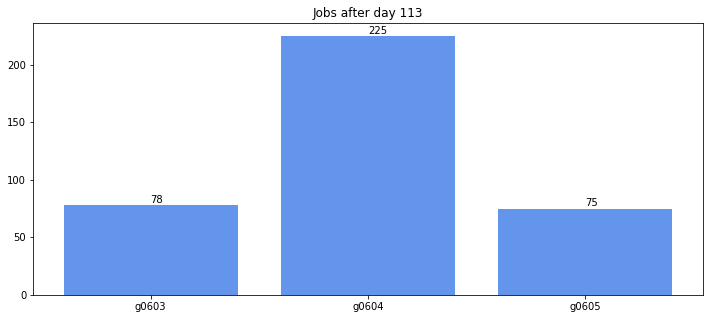

In [88]:
recent_mask = expanded_df["day"] > 113
recent = expanded_df[recent_mask]
fig = counter_histogram(recent["nodelist"])
fig.axes[0].set_title("Jobs after day 113");

You can see from the following records that zombie job records were created on day 113 occupying all the cpu for nodes 601 and 602.  This is the reason no further jobs are scheduled on either node.

In [89]:
day_113_mask = expanded_df["day"] == 113
node_mask = (expanded_df["nodelist"] == "g0601") | (expanded_df["nodelist"] == "g0602")
expanded_df[day_113_mask & node_mask].tail()

,mem_req,cpus_req,gres_req,job_db_inx,time_suspended,time_end,nodelist,time_submit,time_start,job_name,pending,seconds_of_day,day_of_week,gpus_req,runtime,utilization,sum_cpus,sum_gpus,day
3611,4096,8,gpu:1,6524551,0,1496196743,g0602,1496196343,1496196343,EED_4,0,79543,1,1,400.0,0.56250,32,4,113.0
3612,4096,8,gpu:1,6524674,0,0,g0601,1496196927,1496196927,prc2unc_1,0,80127,1,1,NaN,0.03125,1,1,113.0
3613,4096,8,gpu:1,6524676,0,0,g0601,1496196930,1496196932,prc2unc_2,2,80130,1,1,NaN,0.21875,9,5,113.0
3614,4096,8,gpu:1,6524678,0,0,g0602,1496196933,1496196933,prc2unc_3,0,80133,1,1,NaN,0.21875,9,5,113.0
3615,4096,8,gpu:1,6524680,0,0,g0602,1496196936,1496196936,prc2unc_4,0,80136,1,1,NaN,0.25000,10,6,113.0


### Resource utilization of long running jobs

From the following table, you can see that most long running jobs are 1 CPU 1 GPU.

In [115]:
long_running_mask = expanded_df["runtime"] > 100000
long_running = expanded_df[long_running_mask]
long_running.groupby(["cpus_req", "gpus_req"]).count()[["job_db_inx"]].rename(columns={"job_db_inx":"count"})

count
cpus_req gpus_req       
1        1            24
         3             1
         8            11
2        1             1
4        1             2
5        1             5
         4             1
8        4             2
         8             9

In [116]:
query = "select job_name, account, count(*) from longleaf_job_table where time_end = 0 group by job_name, account"
zombie_df = pd.read_sql_query(query, engine)

In [117]:
zombie_df

,job_name,account,count(*)
0,100,rc_dokh_pi,1
1,26Al_spectrum_%a.mac,rc_artc_pi,815
2,aa6-9,rc_chered_pi,1
3,bash,rc_csong_pi,2
4,bash,rc_marzluff_pi,1
5,bash_dummy.sh,rc_bkuhlman_pi,781
6,Bedpost,rc_jmihalik_pi,14
7,Cleanup,rc_johnmcge_pi,25
8,espa_order_download.sh,rc_csong_pi,1
9,flagstat,rc_johnmcge_pi,21
